# Texture synthesis and artistic style transfer

In this homework you are to imlement [A Neural algorithm of artistic style](http://arxiv.org/pdf/1508.06576v2.pdf). This is an extension of [Texture Synthesis Using Convolutional Neural Networks](http://arxiv.org/pdf/1505.07376v3.pdf) method.

The core of the method -- VGG and constrained optimization. The constrains are of two types: *content* and *style*. Given a content image **C** and style image **S** we want to generate an image **X** with content from **C** and style (whatever it really means) from **S**. 

We want to design a loss function for the optimization process. Considering \[1\], \[2\], an input image is easily invertable from the outputs at intermediate layers. This explains the idea of making an intermediate representation $F_X$ of **X** close to **C** representation $F_C$. 

$$
   L_{content} = || F_X - F_C || \rightarrow \min_X
$$

Note, that representation $F$ preserve spatial information. Idea: let us dismiss it, so we will know what objects are there on the picture, but will not be able to reestablish their localtion. The style can be thought as something independent of content, something we are left with if we let the content off. L. Gatys suggests to dismiss spatial information by computing correlations between the feature maps $F$. If $F$ has dimensions `CxWxH`, then correlation matrix will be `CxC`, and look there's no spatial dimentions. So the style term will be responsible for mathing these correlation (Gram) matrices. 

$$
   L_{style} = || Gram(F_X) - Gram(F_C) || \rightarrow \min_X
$$

And finaly we combine the two.

$$
   L = \alpha L_{content} + \beta L_{style} \min_X
$$

Read the paper and the code for the details on layers, features $F$ are got from.

#### A little bit of history behind this texture generation method

Actually the idea comes from 90th, when mathematical models of texures were developed \[3\]. They defined a probabolistic model for texture generation. They used an idea, that two images are indeed two samples of a particular texture iff their statistics match. The statistics used are histograms of given texture $I$ filtered with a number of filters: $\{hist(F_i * I), \quad i = 1,\dots, k\}$. And whatever image has the same statistics is thought as a sample of texture $I$. The main drawback was the Gibbs sampling was employed (which is very slow). \[4\] suggested exactly the scheme we use now: starting from a random image, let's adjust its statistics iteratively so they match the desired. 

Now, what is changed: the filters. \[4\] used carefully crafted set of filters, and now we use neural network based non-linear filters. We still use the idea of matching statistics, but the statistics improved. 

\[1\] *A.Mahendran, A.Vedaldi [Understanding Deep Image Representations by Inverting Them](https://www.robots.ox.ac.uk/~vgg/publications/2015/Mahendran15/mahendran15.pdf)*

\[2\] *A.Dosovitsky, T.Brox [Inverting Visual Representations with Convolutional Networks](http://arxiv.org/pdf/1506.02753v3.pdf)*

\[3\] *Zhu et. al. Filters, 1997 [Random Fields and Maximum Entropy (FRAME):
Towards a Unified Theory for Texture Modeling](http://www.stat.ucla.edu/~ywu/research/papers/ijcv.pdf)*

\[4\] *Portilla & Simoncelli, 2000  [A Parametric Texture Model Based on Joint Statistics
of Complex Wavelet Coefficients](http://www.cns.nyu.edu/pub/lcv/portilla99-reprint.pdf)*

# Homework

To prevent you from technical problems, you may use a [complete code for the method](https://github.com/Lasagne/Recipes/tree/master/examples/styletransfer). 
Your task will be to play around with it. 

### First part
**Common mandatory part**:
- Generate your favourite texture (please, do not use starry night). All you need to do is to set content weight to 0.  
- Stylize your favourite photo with your favourite style (hope you use something interesting).
- Give an explanation for matching Gram matrices. What does it mean to minimize distance between them in terms of random variables? Assume a true distripution $P$, and model distibution $Q$. What class does $Q$ belong when matching gram matrices? Show, that $KL (P || Q)$ is minimized when Gram matrices are matched. In other words you need to come up with $Q$ such that $KL$ divergence is minimized when models gram matrix is equal to a target Gram matix. If you do not understand the question spend more time, please. If you want a hint after all, here is a [Telegram bot for you](https://telegram.me/rdl_hw7_bot) (send /hint to him).

### Second part
We give you **two options** for the second part.

**First one** (if you are lazy or do not have GPU do just this):
- Implement **Mean** and **Covariance** matching functions instead of $Gram$ matching. That is: 
    - *Mean* is a vector of size `C` which containes means over feature maps
    - *Covariance* matrix is a *Gram* matrix of $Feats-mean$
- What is $Q$ now? 
- Generate texture and stylize with $mean$ loss only; with $mean$ + $Covariance$ loss. Plot the results, side by side (3 textures and 3 stylized). What do you think? Actually, $Gram$ matrix or $Mean$ or $Mean$ + $Covariance$ matrix can be thought as texture descriptors. Does $mean$ encoding have enough parameters to represent texures?  
- ***OR*** come up with your method to remove spatial information instead of above.
- Bonus: you can mix several styles, averaging their representations. It can be fun. Some examples are [here](https://github.com/jcjohnson/neural-style).

**Second one** (hardcore):
- Substitute gram matrices with discriminator as in GAN. That is, you match distributions matching gram matrices and discriminator is designed to match distributions. Probably $Q$, we have defined is weak or too constraintive. Neural network based discriminator should be more flexible in this sense.
    - The procedure will be a little bit unusual: we will optimize NN inside optimization loop w.r.t. image.
    - You need to define a pixel level discriminator (at each layer you have $WH$ objects, each with $C$ features). Basically it should decide whether a pixel came from style image or from current image $X$. 
    - So the process is like that: 
        - At each image optimization iteration update D (actually you do not need to do minibatches updates here, you can simulate fully-connected layers with 1x1 convolutions, softmax with sigmoids). You will need to find a trade-off, for how long and how frequent should updates be. 
        - Then propagate gradient just like in GAN when optimizing $G$ i.e. swap labels (another strategy is in [here](https://www.robots.ox.ac.uk/~vgg/rg/papers/Tzeng_ICCV2015.pdf), eq. 4).
        - Let L-BFGS (or whatever, probably adam will be more stable) update $X$.
    - Discriminator architecture is up to you. It's better to start with logistic regression which should emulate $Mean$ + $Cov$ matching (isn't it?). 
    - I tried this myself without content loss only.

**Do everything in this notebook, I need your code as well as the generated images**

HINTS: 

- In case you do not have GPU, you need to substitute the line:
  
  `from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer`

   with

   `from lasagne.layers import Conv2DLayer as ConvLayer`
   
   
- If you do not have GPU, resize your images to 256x256 and no more. Even at this resolution it may take an hour. You can decrease the number of iterations if it takes too long. 

In [1]:
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [2]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# VGG-19, 19-layer model from the paper:
# "Very Deep Convolutional Networks for Large-Scale Image Recognition"
# Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
# License: non-commercial use only

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_W = 600

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGE_W, IMAGE_W))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

In [4]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl

--2017-04-07 18:16:30--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.41.18
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.41.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80126892 (76M) [binary/octet-stream]
Saving to: ‘vgg19_normalized.pkl.1’

vgg19_normalized.pk 100%[===================>]  76.41M  17.0MB/s    in 7.6s    

2017-04-07 18:16:38 (10.1 MB/s) - ‘vgg19_normalized.pkl.1’ saved [80126892/80126892]



In [7]:
net = build_model()

values = pickle.load(open('vgg19_normalized.pkl', 'rb'), encoding='latin1')['param values']
lasagne.layers.set_all_param_values(net['pool5'], values)

In [8]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGE_W, w*IMAGE_W//h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGE_W//w, IMAGE_W), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGE_W//2:h//2+IMAGE_W//2, w//2-IMAGE_W//2:w//2+IMAGE_W//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

/home/ubuntu/env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


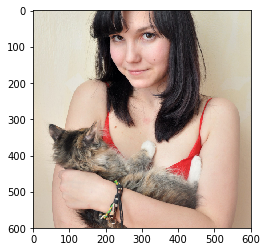

In [10]:
photo = plt.imread('avatar.jpeg')
rawim, photo = prep_image(photo)
plt.imshow(rawim)

/home/ubuntu/env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


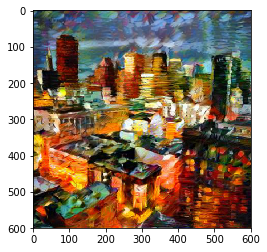

In [23]:
art = plt.imread('rain_sanfrancisco.jpeg')
rawim, art = prep_image(art)
plt.imshow(rawim)

In [12]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [52]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [53]:
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

photo_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({input_im_theano: art}))
                for k, output in zip(layers.keys(), outputs)}

/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [54]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode=self.mode,
/home/ubuntu/env/src/lasagne/lasagne/layers/pool.py:266: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode=self.mode,


In [55]:
# Define loss function
losses = []

# content loss
losses.append(0.008 * content_loss(photo_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(art_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [56]:
grad = T.grad(total_loss, generated_image)

In [57]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [58]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(20):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [46]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

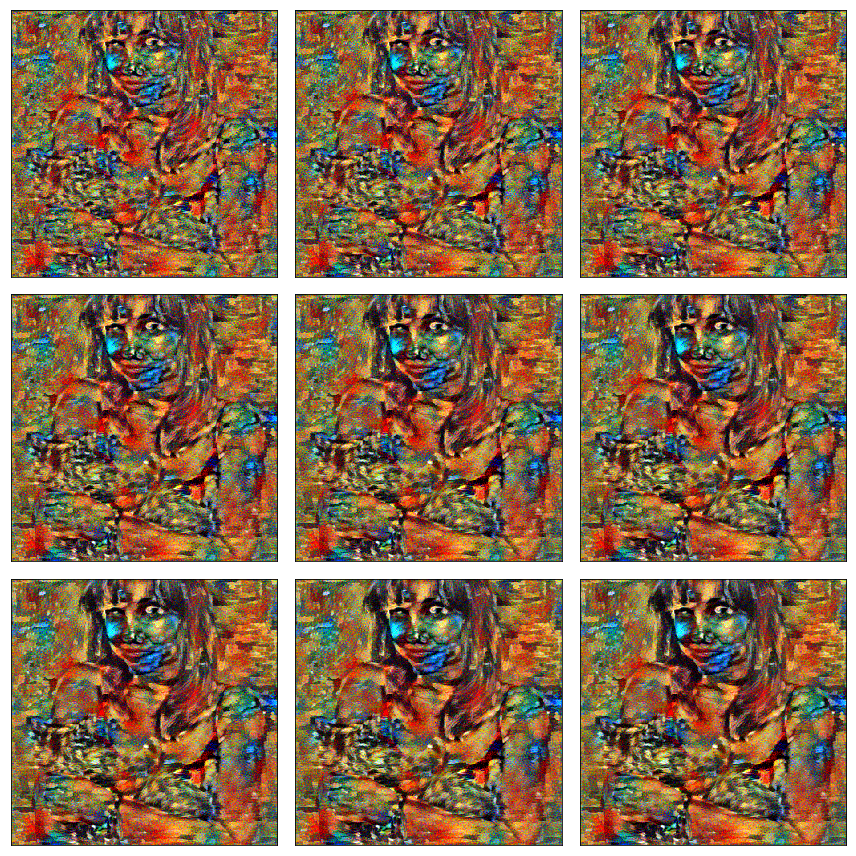

In [59]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)   
    plt.imshow(deprocess(xs[i + 5]))
plt.tight_layout()